In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import cifar10
from keras import models, regularizers, optimizers, losses
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, Input, BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from sklearn import metrics

In [13]:
LABELS= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Define the confusion matrix for the results
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)  # Don't rotate (vertically) the y-axis labels
    #hm.invert_yaxis() # Invert the labels of the y-axis
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [14]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

img_rows, img_cols = train_x.shape[1], train_x.shape[2]
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

train_x /= 255
test_x /= 255

num_class = np.size(np.unique(train_y))

train_y = to_categorical(train_y, num_class)
test_y = to_categorical(test_y, num_class)

In [15]:
print(train_x.shape)
print(train_y.shape)
print(num_class)

(50000, 32, 32, 3)
(50000, 10)
10


In [16]:
model = models.Sequential()
model.add(Input(input_shape))
model.add(Conv2D(16, (3,3), activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.30))
model.add(Flatten())
model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.30))
model.add(Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,866 (327.60 KB)

 Trainable params: 83,738 (327.10 KB)

 Non-trainable params: 128 (512.00 B)

In [17]:
epochs = 20
batch_size = 128
opt = optimizers.Adam(0.001)
loss = losses.categorical_crossentropy

model.compile(loss=loss,
              optimizer=opt,
              metrics=['acc'])

In [18]:
history = model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = (test_x, test_y),
          verbose=1)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - acc: 0.3339 - loss: 2.0425 - val_acc: 0.3225 - val_loss: 2.2755
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - acc: 0.4729 - loss: 1.5894 - val_acc: 0.5519 - val_loss: 1.3891
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - acc: 0.5405 - loss: 1.4089 - val_acc: 0.6026 - val_loss: 1.2208
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - acc: 0.5795 - loss: 1.2988 - val_acc: 0.6393 - val_loss: 1.1121
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - acc: 0.6023 - loss: 1.2299 - val_acc: 0.6595 - val_loss: 1.0615
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - acc: 0.6202 - loss: 1.1803 - val_acc: 0.6513 - val_loss: 1.0781
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - acc: 0.6342 - loss: 1.1434 - val_acc: 0.6796 - val_loss: 1.0049
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - acc: 0.6481 - loss: 1.1052 - val_acc: 0.6701 - val_loss: 1.0331
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 

In [19]:
score = model.evaluate(test_x, test_y, verbose=0)
pred_y = model.predict(test_x)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Validation loss: 0.865990400314331
Validation accuracy: 0.7279999852180481


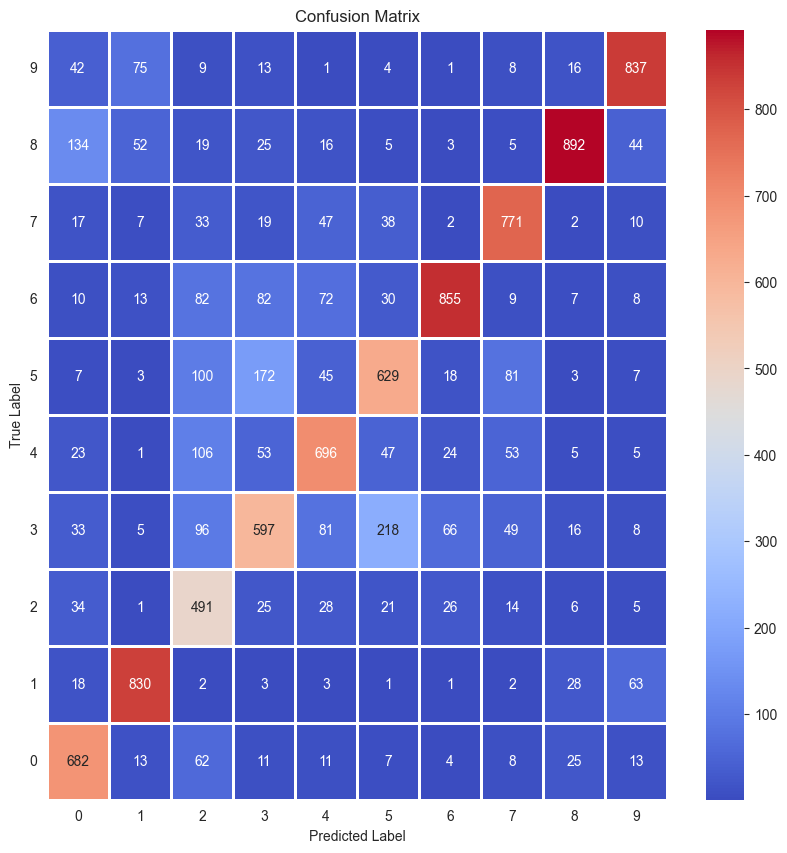

In [20]:
max_pred_y = np.argmax(pred_y, axis=1)
max_test_y = np.argmax(test_y, axis=1)
show_confusion_matrix(max_pred_y, max_test_y, num_class)

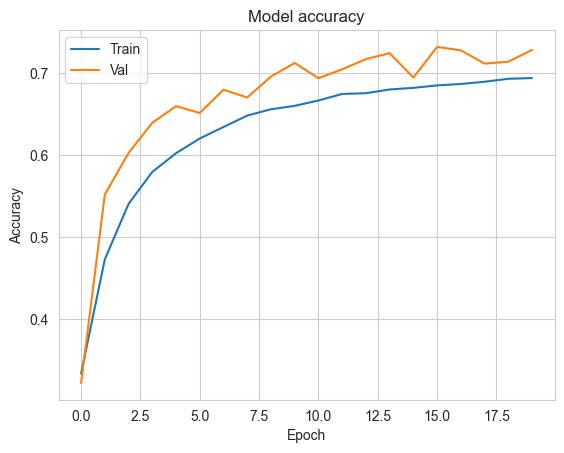

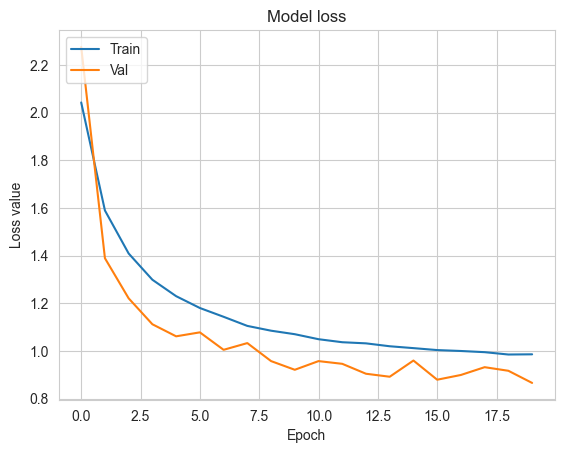

In [21]:
acc = history.history['acc']
loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()